# Introductie extreme waarde statistiek met python

Disclaimer: ik ben geen statisticus. 

Ik was op zoek naar extreme waarde statistiek voor onze debietreeksen. In een vorig leven heb ik wel is extreme waarde statistiek toegepast met de R-package [extRemes](https://cran.r-project.org/web/packages/extRemes/index.html) (aanrader), omdat ik op mijn werk enkel beschikking heb tot python, het nu maar is in python gedaan. Het bleek lastiger dan ik dacht om goede voorbeelden en packages te vinden vandaar dit artikel.

## Extreme waarde statistiek, wat is dat?
Op naar <a href="https://nl.wikipedia.org/wiki/Extreme_waarde_(kansrekening)">Wikipedia</a>  
_In de kansrekening en de statistiek is een extreme waarde het maximum of het minimum in een aselecte steekproef. In de theorie over extreme waarden bestudeert men de mogelijke verdeling van de extreme waarden._ 

_Centraal in de theorie staat het resultaat dat onder bepaalde voorwaarden als limietverdeling voor een extreme waarde slechts drie verdelingen mogelijk zijn, onafhankelijk van de oorspronkelijke verdeling in de steekproef._

Ok, ok, extreme waarde statistiek gaat dus over evenementen die ver afwijken van het standaard gedrag, logisch, extremen. Daarbij is er ook vaak het doel om iets te zeggen over extremen die we nog niet hebben waargenomen, extrapolatie. Daarom fitten we een extreme waardeverdeling (zoals bijv. Gumbel) op onze geobserveerde extremenwaardenset. Als we een extreme waardeverdeling hebben die goed past kunnen we iets zeggen over herhalingstijden en overschrijdingskansen, super mooi!

Extreme waardestatistiek wordt in de hydrologie bijvoorbeeld toegepast bij extreme neerslag of afvoer. Buiten de hydrologie kan je denken aan bijv. in de klimatologie extreme golfhoogtes, tornado's, maar ook in de bouw of financiele sector wordt extreme waarde statistiek toegepast.

Hier gaan we kijken naar debieten, dus afvoeren van de Rijn bij Lobith, omdat dit een set is waar iedereen makkelijk bij kan. De set kan je downloaden op [Waterinfo](https://waterinfo.rws.nl/#!/nav/bulkdownload/alle-groepen/).

## Data inladen en visualiseren

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

%matplotlib inline

q = pd.read_csv('lobith.csv', sep=';', decimal=',', encoding='iso-8859-1', 
                  parse_dates=[['WAARNEMINGDATUM', 'WAARNEMINGTIJD']],
                  infer_datetime_format=True, dayfirst=True, 
                  usecols=['MEETPUNT_IDENTIFICATIE', 'WAARNEMINGDATUM', 'WAARNEMINGTIJD', 'NUMERIEKEWAARDE'],
                 )
q = q.set_index(['MEETPUNT_IDENTIFICATIE', 'WAARNEMINGDATUM_WAARNEMINGTIJD']) # ik gebruik hier mijn standaard om rws data in 
# te laden dan kan je ook sets met meerdere meetpunten uit een csv in een keer simpel inladen
lobith = q.loc['Lobith'] # juiste meetpunt selecteren
lobith = lobith.resample('d').mean() # 10-min data hebben we niet nodig
lobith = lobith[lobith < 99999] # nan-values zijn niet eenduidig (zitten in de orde 10e36-37) dus selecteer de logische waardes
lobith = lobith.squeeze() # maak er een series van

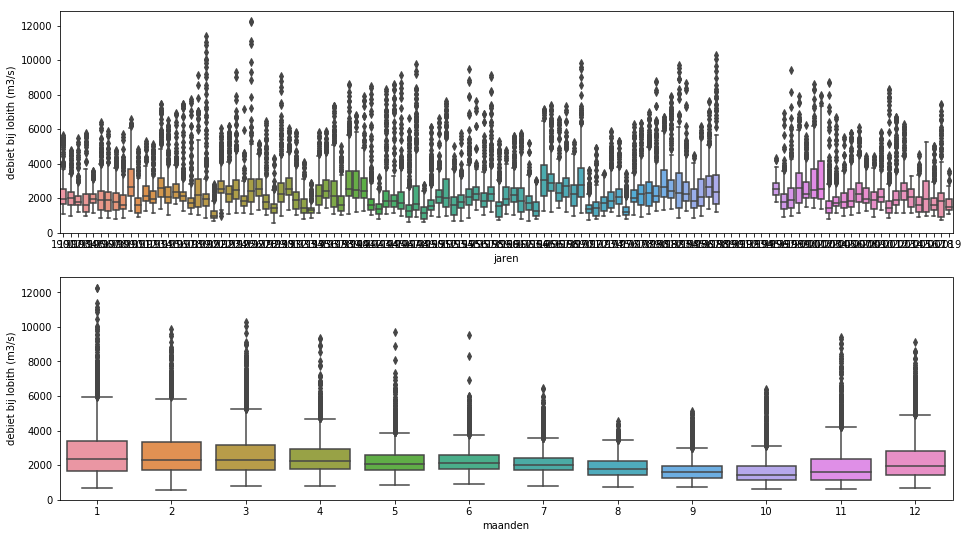

In [2]:
import seaborn as sns

# plotje om idee te krijgen van de reeks
fig, ax = plt.subplots(2, 1, figsize=(16,9))
sns.boxplot(x=lobith.index.year.values, y=lobith.values, ax=ax[0])
ax[0].set_xlabel('jaren')
ax[0].set_ylabel('debiet bij lobith (m3/s)')
sns.boxplot(x=lobith.index.month.values, y=lobith.values, ax=ax[1])
ax[1].set_xlabel('maanden')
ax[1].set_ylabel('debiet bij lobith (m3/s)');

## Jaarlijkse maxima of peak-over-threshold
Het makkelijkste is om gewoon alle maxima per jaar te selecteren, dit kan simpel in pandas door bijvoorbeeld te resamplen. Peak-over-threshold is iets lastiger omdat je alleen onafhankelijke evenementen wil, een extreme afvoer kan meerdere dagen duren, je wil dan enkel het maximum hebben. Gelukkig heeft scipy een oplossing [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html), hier kan je een distance aangeven ofwel hoever dienen pieken minimaal uit elkaar te liggen. Je peak-over-threshold zou een vergelijkbaar aantal extreme waarden moeten hebben als het aantal jaar, dus speel een beetje met de quantiles.

In [3]:
from scipy.signal import find_peaks

am = lobith.loc[lobith.groupby(lobith.index.year).idxmax().dropna().values] # annual maximum methode, groepeer per jaar en 
# gebruik de index van het maxima
pot = lobith.iloc[find_peaks(lobith, height=lobith.quantile(0.98), distance=7)[0]] #peak-over-threshold methode, gebruikt
# kwantielen om een indicatie te krijgen voor hoge afvoeren, hier 98% kwantiel, en pieken moeten minimaal een week uit elkaar
# liggen

In [4]:
print('lengte annual maximum:', len(am), ' lengte peak-over-threshold:', len(pot))

lengte annual maximum: 112  lengte peak-over-threshold: 131


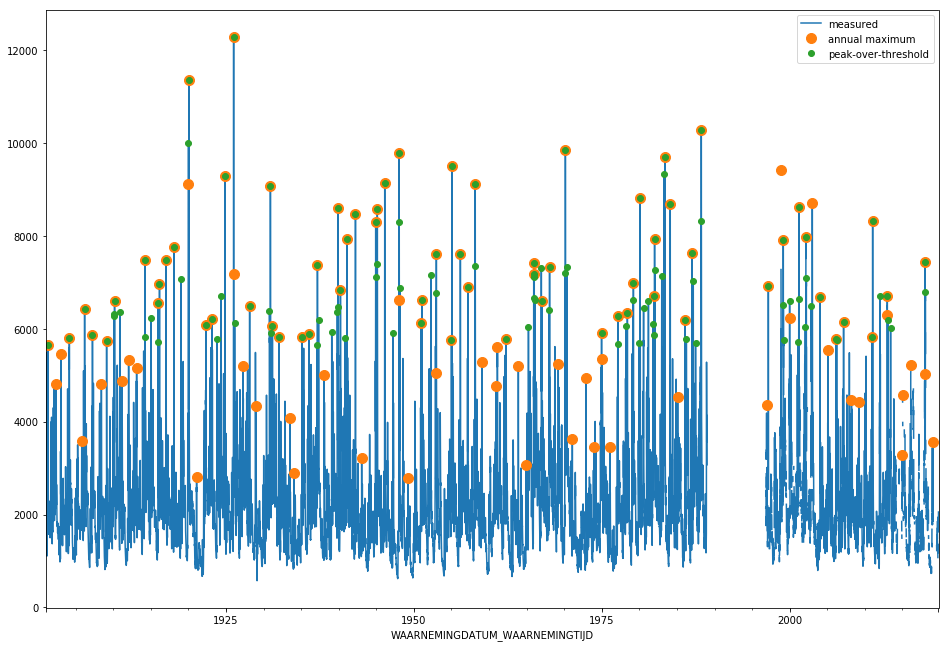

In [5]:
ax = lobith.plot(figsize=(16,11), label='measured')
am.plot(style='o', markersize=10, ax=ax, label='annual maximum')
pot.plot(style='o', ax=ax, label='peak-over-threshold')
plt.legend();

## De statistiek
Eindelijk de statistiek, ik heb de package [lmoments3](https://pypi.org/project/lmoments3/), die kan wat ik wil. Hieronder de resultaten voor 3 van de bekendere extremewaarde verdelingen voor debieten, voor zowel de annual maxima methode als de peak-over-threshold methode. De package heeft nog veel meer verdelingen om mee te spelen.

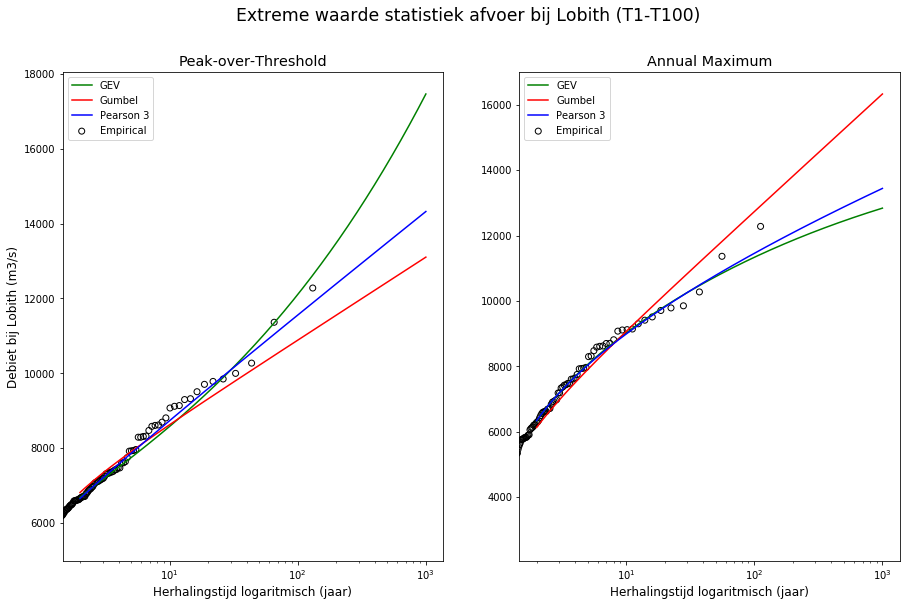

In [6]:
from lmoments3 import distr

fig, ax = plt.subplots(1, 2, figsize=(15,9))
for idx, data in enumerate([pot, am]):
    theta = distr.gev.lmom_fit(data) # fit gev op de geprepareerde pot-data
    gev = distr.gev(**theta) # bereken de verdeling met de parameters uit de fit
    theta = distr.gum.lmom_fit(data)
    gum = distr.gum(**theta)
    theta = distr.pe3.lmom_fit(data)
    pe3 = distr.pe3(**theta)

    T = np.arange(1, 999.1, 0.1) + 1 # herhalingstijden van T1 tot T1000
    ax[idx].plot(T, gev.ppf(1.0-1./T), 'g', label='GEV') # ppf ofwel percent point feature, gebruiken om de debieten bij de herhalings
    # tijden te bepalen, 1.0-1./T -> overschrijdingskans
    ax[idx].plot(T, gum.ppf(1.0-1./T), 'r', label='Gumbel')
    ax[idx].plot(T, pe3.ppf(1.0-1./T), 'b', label='Pearson 3')

    N = np.arange(1, len(data)+1, 1.0) # array met van 1 tot n+1, 1.0 want moeten floats zijn
    Nmax = max(N) # aantal datapunten + 1

    ax[idx].scatter(Nmax/N, sorted(data)[::-1], color = 'black', facecolors='none', label='Empirical') # T = rank datapunt / 
    # (1 + lengte datapunten), daarom dus punten sorteren van hoog naar laag en bijbehorende herhalings tijd is idx / Nmax
    ax[idx].set_xscale('log')
    ax[idx].set_xlabel('Herhalingstijd logaritmisch (jaar)', size='large')
    ax[idx].legend()
ax[0].set_ylabel('Debiet bij Lobith (m3/s)', size='large')
ax[0].set_title('Peak-over-Threshold', size='x-large')
ax[1].set_title('Annual Maximum', size='x-large')
fig.suptitle('Extreme waarde statistiek afvoer bij Lobith (T1-T100)', size='xx-large')
plt.show()